# Import & Config

In [1]:
import pandas as pd
import numpy as np
import copy
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog
import math
import scipy.stats

# Implementation Most Recent


In [ ]:
# Test Case
n = 5 # Size of ground set U = {0, 1, 2, ..., n}
sets = [
    {0, 1},
    {0, 2},
    {0, 3},
    {0, 4},
    {0, 4, 1},
    {0, 1}
]
colors = [0, 0, 1, 1, 1, 1] # 0 --> red, 1 --> blue
m = len(sets) # Number of sets

In [ ]:
def get_point_to_set_hashmap(sets):
    point_to_sets = {}
    for i, s in enumerate(sets):
        for point in s:
            if point not in point_to_sets.keys():
                point_to_sets[point] = []
            point_to_sets[point].append(i)
    return point_to_sets

def get_color_to_set_hashmap(sets, colors):
    color_to_sets = {}
    for i, s in enumerate(sets):
        if colors[i] not in color_to_sets.keys():
            color_to_sets[colors[i]] = []
        color_to_sets[colors[i]].append(i)
    return color_to_sets

## Greedy Standard

In [ ]:
# Greedy
def standard_set_cover(n, sets):
    # Pre-process
    sets = copy.deepcopy(sets)
    point_to_sets = get_point_to_set_hashmap(sets)

    cover = []

    # Main Loop
    while True:
        # Find largest set
        largest_set = np.argmax([len(s) for s in sets])

        # Break if all points are covered
        if len(sets[largest_set]) == 0:
            break

        # Add to cover
        cover.append(largest_set)

        # Remove covered ones
        for covered_point in copy.deepcopy(sets[largest_set]):
            for i in point_to_sets[covered_point]:
                covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

# standard_set_cover(n, sets)

## Naive Fair

In [ ]:
def naive_fair_set_cover(n, sets, colors):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    unfair_cover = standard_set_cover(n, copy.deepcopy(sets))

    # Add arbitrary sets from other colors
    cover_colors, color_counts = np.unique([colors[s] for s in unfair_cover], return_counts=True)
    max_color = max(color_counts)
    for color in color_to_sets.keys():
        if color in cover_colors:
            to_add = max_color - color_counts[cover_colors.tolist().index(color)]
        else:
            to_add = max_color

        cand_sets = color_to_sets[color]
        index = 0
        while to_add > 0:
            if cand_sets[index] not in unfair_cover:
                unfair_cover.append(cand_sets[index])
                to_add -= 1
            index += 1

    return unfair_cover

# naive_fair_set_cover(n, sets, colors)

## All Pick

In [ ]:
def permute(list, per, position, all):
    if position == len(list):
        all.append(per)
    else:
        for i in range(list[position]):
            tmp = copy.deepcopy(per)
            tmp[position] = i
            permute(list, tmp, position + 1, all)

final = []
permute([39, 32, 29], [0, 0, 0], 0, final)
print(final[29 * 31 + 20 + 8])

[0, 31, 28]


In [ ]:
'''
Find fair max cover by picking a pair at each step.
Checks all possible pairs at each step.
'''
def all_pick_fair_set_cover(n, sets, colors):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    cover = []
    keys = [i for i in range(len(color_to_sets.keys()))]
    sets_picked = [False for _ in range(len(sets))]

    # Main Loop
    while True:
        # Find Largest Pair
        max_union = len(set().union(*[sets[color_to_sets[key][0]] for key in keys]))
        picked_pair = tuple([color_to_sets[key][0] for key in keys])

        all_permutes = []
        permute(
            [len(color_to_sets[i]) for i in keys],
            [0 for _ in keys],
            0,
            all_permutes
        )

        for pair in all_permutes:
            union = len(set().union(*[sets[color_to_sets[i][j]] for i, j in enumerate(pair)]))
            if union > max_union:
                max_union = union
                picked_pair = tuple([color_to_sets[i][j] for i, j in enumerate(pair)])

        # Break if all points covered
        if max_union == 0:
            break

        # Add to cover
        cover += [*picked_pair]
        for p in picked_pair:
            sets_picked[p] = True

        # Remove covered points
        for p in picked_pair:
            for covered_point in copy.deepcopy(sets[p]):
                for i in point_to_sets[covered_point]:
                    covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

# all_pick_fair_set_cover(n, sets, colors)

## Efficient All Pick

In [ ]:
def approx_best_pair(sets, point_to_sets, color_to_sets, n, m, covered, sets_picked):
    '''
    max sum(y_j)
        sum(x_i) >= y_j; for each y_j,
        sum(x_i) = 1; for each color,
        0 <= y_j <= 1,
        0 <= x_i <= 1
    '''
    # [y_1, ..., y_n, x_1, ..., x_m]
    c = [0 for i in range(m)] + [-1 for j in range(n)]
    C1 = []
    for j in range(n):
        if covered[j]:
            continue
        c1 = [0 for i in range(m + n)]
        s = point_to_sets[j]
        c1[j + m] = 1
        for i in s:
            c1[i] = -1
        C1.append(c1)

    C2 = []
    C3 = []
    for color in color_to_sets.keys():
        c2 = [0 for i in range(m + n)]
        c3 = [0 for i in range(m + n)]
        s = color_to_sets[color]
        for i in s:
            if sets_picked[i]:
                continue
            c2[i] = 1
            c3[i] = -1
        C2.append(c2)
        C3.append(c3)

    b = [0 for _ in range(len(C1))] + [1 for _ in range(len(color_to_sets))] + [-1 for _ in range(len(color_to_sets))]
    bounds = [(0, 1) for _ in range(n + m)]

    A = C1 + C2 + C3

    res = linprog(c=c, A_ub=A, b_ub=b, bounds=bounds)

    return res

In [ ]:
'''
Find fair max cover by picking a pair at each step.
Finds an approximation of best possible pair by rounding an LP
'''
def efficient_pick_set_cover(n, sets, colors):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    cover = []
    points_covered = [False for _ in range(n)]
    sets_picked = [False for _ in range(len(sets))]
    m = len(sets)
    keys = [i for i in range(len(color_to_sets.keys()))]

    # Main Loop
    while True:
        # Break if all points covered
        if np.all(points_covered):
            break

        # Find Largest Pair
        res = approx_best_pair(
            sets,
            point_to_sets,
            color_to_sets,
            n,
            m,
            points_covered,
            sets_picked
        )
        picked_pair = tuple([
            np.random.choice(color_to_sets[i], 1, p=res.x[:m][color_to_sets[i]])[0]
            for i in keys
        ])

        # Add to cover
        cover += [*picked_pair]
        for p in picked_pair:
            sets_picked[p] = True

        # Remove covered points
        for p in picked_pair:
            for covered_point in copy.deepcopy(sets[p]):
                points_covered[covered_point] = True
                for i in point_to_sets[covered_point]:
                    covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

# efficient_pick_set_cover(n, sets, colors)

## Generalized

In [ ]:
def gen_permute(list, per, constraint, position, all, starts):
    if position == len(list):
        all.append(per)
    else:
        for i in range(starts[constraint[position]], list[position]):
            tmp = copy.deepcopy(per)
            s = copy.deepcopy(starts)
            s[constraint[position]] = i + 1
            tmp[position] = i
            gen_permute(list, tmp, constraint, position + 1, all, s)

final = []
# gen_permute([40, 40, 40, 40, 40], [0, 0, 0, 0, 0], [0, 1, 1, 1, 1], 0, final, [0, 0])
# [101, 99, 99, 99, 99], [0, 0, 0, 0, 0], [0, 1, 1, 1, 1]
# final

In [ ]:
from itertools import product, combinations

def permute_eff(extended_colors, color_to_sets):
    combs = [combinations(color_to_sets[c], extended_colors.count(c)) for c in range(len(color_to_sets.keys()))]
    for pair in product(*combs):
        a = []
        [a.extend([s for s in p]) for p in pair]
        print(a)

permute_eff(extended_colors=[1, 0, 0], color_to_sets={1: {1, 2, 3}, 0: {4, 5, 6}})

[4, 5, 1]
[4, 5, 2]
[4, 5, 3]
[4, 6, 1]
[4, 6, 2]
[4, 6, 3]
[5, 6, 1]
[5, 6, 2]
[5, 6, 3]


In [ ]:
def get_extended_colors(ratios, L):
    ratios = [int(x * L) for x in ratios]
    gcd = math.gcd(*ratios)
    ratios = [x // gcd for x in ratios]
    # return ratios
    extended_colors = []
    for i, rate in enumerate(ratios):
        extended_colors += [i for _ in range(rate)]

    return extended_colors


get_extended_colors([0.1, 0.2, 0.7], 1000)

[0, 1, 1, 2, 2, 2, 2, 2, 2, 2]

In [ ]:
def generalized_all_pick(n, sets, colors, ratios):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    cover = []
    keys = [i for i in range(len(color_to_sets.keys()))]
    sets_picked = [False for _ in range(len(sets))]
    extend_colors = get_extended_colors(ratios, 1000)

    # Main Loop
    while True:
        # Find Largest Pair
        max_union = None
        picked_pair = None
        # for c in keys:
        #     picked_pair += color_to_sets[c][:extend_colors.count(c)]

        # max_union = len(set().union(*[sets[s] for s in picked_pair]))
        # picked_pair = tuple(picked_pair)
        # print(picked_pair, max_union, [sets[s] for s in picked_pair])
        # break

        all_permutes = []
        print(f"Start of comb: {[len(color_to_sets[i]) for i in extend_colors], [0 for _ in extend_colors], extend_colors}")
        # gen_permute(
        #     [len(color_to_sets[i]) for i in extend_colors],
        #     [0 for _ in extend_colors],
        #     extend_colors,
        #     0,
        #     all_permutes,
        #     [0 for _ in keys]
        # )
        # print("end")

        combs = [combinations(list(filter(lambda x: len(sets[x]) > 0, color_to_sets[c])), extend_colors.count(c)) for c in range(len(color_to_sets))]
        print("end")
        updated = False
        for pair in product(*combs):
            tmp = []
            [tmp.extend([s for s in p]) for p in pair]
            pair = tmp
            union = len(set().union(*[sets[s] for s in pair]))
            if max_union is None or union > max_union:
                updated = True
                max_union = union
                picked_pair = tuple(pair)

        # Break if all points covered
        if max_union == 0 or max_union is None:
            break

        # Not Found!
        # if not updated:
        #     return []

        # Add to cover
        cover += [*picked_pair]
        for p in picked_pair:
            sets_picked[p] = True

        # Remove covered points
        for p in picked_pair:
            for covered_point in copy.deepcopy(sets[p]):
                for i in point_to_sets[covered_point]:
                    covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

generalized_all_pick(n, sets, colors, [0.6, 0.3])

Start of comb: ([2, 2, 4], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([2, 2, 4], [0, 0, 0], [0, 0, 1])
end


[0, 1, 2]

In [ ]:
def gen_LP(sets, point_to_sets, color_to_sets, n, m, covered, sets_picked, p_stars):
    '''
    max sum(y_j)
        sum(x_i) >= y_j; for each y_j,
        sum(x_i) = 1; for each color,
        0 <= y_j <= 1,
        0 <= x_i <= 1
    '''
    # [y_1, ..., y_n, x_1, ..., x_m]
    c = [0 for i in range(m)] + [-1 for j in range(n)]
    C1 = []
    for j in range(n):
        if covered[j]:
            continue
        c1 = [0 for i in range(m + n)]
        s = point_to_sets[j]
        c1[j + m] = 1
        for i in s:
            c1[i] = -1
        C1.append(c1)

    C2 = []
    C3 = []
    for color in range(len(color_to_sets.keys())):
        # print("c: ", color)
        c2 = [0 for i in range(m + n)]
        c3 = [0 for i in range(m + n)]
        s = color_to_sets[color]
        for i in s:
            if sets_picked[i]:
                continue
            c2[i] = 1
            c3[i] = -1
        C2.append(c2)
        C3.append(c3)

    b = [0 for _ in range(len(C1))] + [p for p in p_stars] + [-p for p in p_stars]
    bounds = [(0, 1) for _ in range(n + m)]

    A = C1 + C2 + C3

    res = linprog(c=c, A_ub=A, b_ub=b, bounds=bounds)

    return res

def eff_gen_pick(n, sets, colors, ratios):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    cover = []
    points_covered = [False for _ in range(n)]
    sets_picked = [False for _ in range(len(sets))]
    m = len(sets)
    keys = [i for i in range(len(color_to_sets.keys()))]
    extend_colors = get_extended_colors(ratios, 1000)
    p_stars = [extend_colors.count(color) for color in keys]
    # print(p_stars)

    # Main Loop
    while True:
        # Break if all points covered
        if np.all(points_covered):
            break

        # Find Largest Pair
        res = gen_LP(
            sets,
            point_to_sets,
            color_to_sets,
            n,
            m,
            points_covered,
            sets_picked,
            p_stars
        )
        if not res.success:
            break
        picked_pair = []
        for i in keys:
            # print("unique: ", np.unique(res.x[:m], return_counts=True), "desired count: ", p_stars[i], "0 count: ", np.unique(res.x[:m][color_to_sets[0]], return_counts=True), "1 count: ", np.unique(res.x[:m][color_to_sets[1]], return_counts=True))
            cans = [*np.random.choice(color_to_sets[i], size=p_stars[i], p=res.x[:m][color_to_sets[i]]/sum(res.x[:m][color_to_sets[i]]), replace=False)]
            # print(np.unique(np.array(cans)), cans)
            uni = np.unique(np.array(cans))
            cans = [i for i in uni]
            if len(uni) < p_stars[i]:
                ind = 0
                for s in color_to_sets[i]:
                    if ind == p_stars[i] - len(uni):
                        break
                    if not sets_picked[s] and not s in picked_pair and not s in cans:
                        cans.append(s)
                        ind += 1

            picked_pair += cans

        # print(picked_pair)

        # Add to cover
        cover += [*picked_pair]
        for p in picked_pair:
            sets_picked[p] = True

        # Remove covered points
        for p in picked_pair:
            for covered_point in copy.deepcopy(sets[p]):
                points_covered[covered_point] = True
                for i in point_to_sets[covered_point]:
                    covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

eff_gen_pick(n, sets, colors, [0.6, 0.3])

[0, 1, 2]

In [ ]:
a = [(1, "s"), (2, "a"), (3, "h")]
min(a, key=lambda x: x[0])

(1, 's')

In [ ]:
# Two color case!
def naive_generalized(n, sets, colors, ratios):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    unfair_cover = standard_set_cover(n, copy.deepcopy(sets))
    extended = get_extended_colors(ratios, 1000)

    # Add arbitrary sets from other colors
    cover_colors, color_counts = np.unique([colors[s] for s in unfair_cover], return_counts=True)
    # print(cover_colors)
    # print(color_counts)
    # print(extended)
    min_rate, c = min([(extended.count(c) / color_counts[cover_colors.tolist().index(c)], c) for c in range(len(color_to_sets.keys()))], key=lambda x: x[0])
    min_rate = math.ceil(min_rate)
    extended *= int(math.lcm(extended.count(c), color_counts[cover_colors.tolist().index(c)]) / extended.count(c))

    for color in color_to_sets.keys():
        if color in cover_colors:
            to_add = extended.count(color) - color_counts[cover_colors.tolist().index(color)]
        else:
            to_add = extended.count(color)

        cand_sets = color_to_sets[color]
        index = 0
        while to_add > 0:
            if cand_sets[index] not in unfair_cover:
                unfair_cover.append(cand_sets[index])
                to_add -= 1
            index += 1

    return unfair_cover

naive_generalized(n, sets, colors, ratios=[0.3, 0.6])

[1999, 23, 131, 970, 974, 94, 0, 2, 3, 6, 7, 8]

## Opt

### Standard Solution

In [ ]:
def opt_standard_solution(n, sets, max_length):
    for cover_size in range(max_length + 1):
        for cover in itertools.combinations(sets, cover_size):
            union = set().union(*cover)
            if len(union) == n:
                return [sets.index(c) for c in cover]

opt_standard_solution(n, sets, max_length=4)

[1, 2, 4]

### Fair Solution

In [ ]:
def opt_fair_solution(n, sets, colors, max_length):
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    blue_sets = color_to_sets[0]
    red_sets = color_to_sets[1]

    for cover_size in range(2, max_length + 2, 2):
        for blue in itertools.combinations(blue_sets, cover_size // 2):
            for red in itertools.combinations(red_sets, cover_size // 2):
                blue_subset = [sets[i] for i in blue]
                red_subset = [sets[i] for i in red]
                union = set().union(*blue_subset)
                union = union.union(*red_subset)
                if len(union) == n:
                    return list(red + blue)

opt_fair_solution(n, sets, colors, max_length=6)

[2, 3, 0, 1]

# Generate Data

In [ ]:
# Config
N = 20 # Size of ground set
M = 2000 # Number of sets
K = 2 # Number of colors

In [ ]:
def generate(N, M, K, sizes_list, set_cover_dist, colors_prob):
    ground_set = np.arange(N)
    sets = []
    colors = np.random.choice(np.arange(K), size=M, p=colors_prob)
    for size in sizes_list:
        if size <= 0:
            size = 1
        if size >= N:
            size = N

        # Generate a set on ground set
        probs = [set_cover_dist.pdf(x) for x in ground_set]
        probs = probs / sum(probs)
        sets.append(np.random.choice(ground_set, p=probs, replace=False, size=int(size)))

        # Cover all points
        counts = [0 for _ in ground_set]

    # Cover all uncovered points
    for j in ground_set:
        for s in sets:
            if j in s:
                counts[j] += 1
    not_covered = []
    for i, c in enumerate(counts):
        if c == 0:
            not_covered.append(i)
    sets[-1] = np.int64(np.append(sets[-1], not_covered))

    return ground_set, [set(s) for s in sets], colors

# Distribution of size of sets
sizes_list = np.round(np.random.normal(loc=4, scale=1, size=M))
# Distribution of sets coverage over ground set
set_cover_dist = scipy.stats.norm(loc=N/2, scale=2)
# set_cover_dist = scipy.stats.uniform(loc=0, scale=N)
ground_set, sets, colors = generate(N, M, K, sizes_list, set_cover_dist, np.array([1, 1]) / 2)

Text(0.5, 12.44444444444443, 'Set Size')

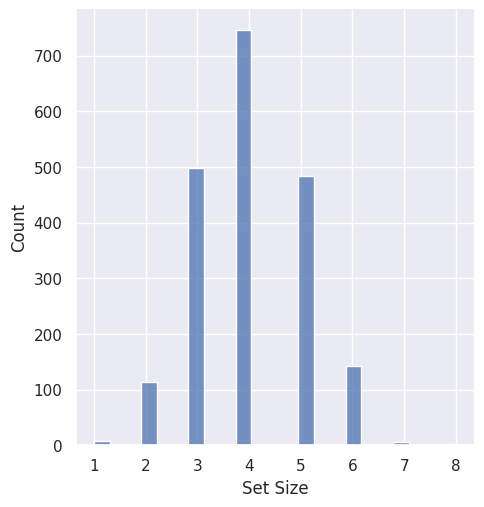

In [ ]:
sns.displot([len(s) for s in sets]);
plt.xlabel("Set Size")

Text(0.5, 0, 'Point in ground set')

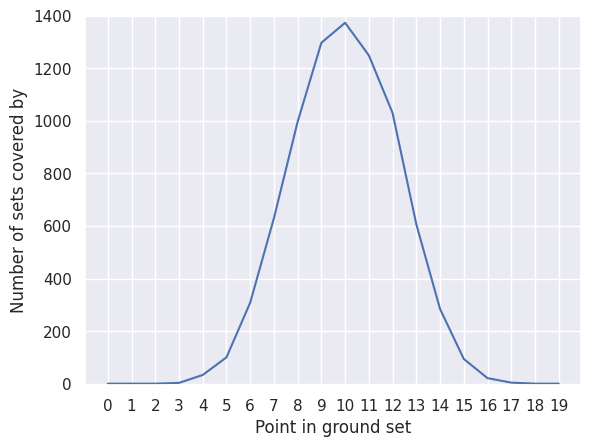

In [ ]:
counts = [0 for _ in ground_set]

for j in ground_set:
    for s in sets:
        if j in s:
            counts[j] += 1

plt.plot(ground_set, counts)
plt.xticks(ground_set)
plt.ylim(-5, 1400)
plt.ylabel("Number of sets covered by")
plt.xlabel("Point in ground set")

(array([1025.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         975.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

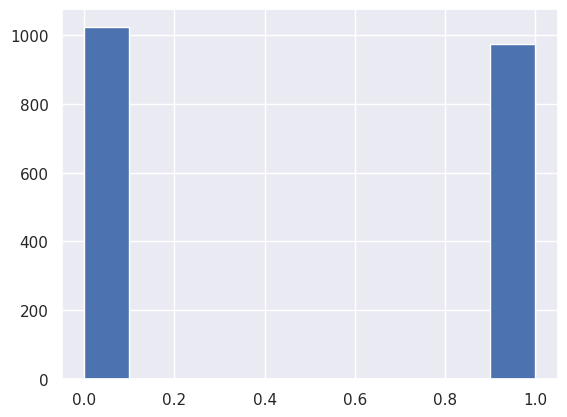

In [ ]:
plt.hist(colors)

# Run Experiments

In [ ]:
def run_with_time(func, *args):
    start_time = time.time()
    res = func(*args)
    run_time = time.time() - start_time
    return (res, run_time)

def run_all(n, sets, colors):
    results = {}

    results["SC"] = run_with_time(standard_set_cover, n, copy.deepcopy(sets))
    results["Naive"] = run_with_time(naive_fair_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    results["AllPick"] = run_with_time(all_pick_fair_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    results["EffAllPick"] = run_with_time(efficient_pick_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))

    return results

In [ ]:
def run_experiments(M, K, N, runs_per_n, colors_prob, set_cover_dist, sizes_list):
    result_df_times = {"N": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
    result_df_counts = {"N": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
    result_df_fairness = {"N": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}

    for n in N:
        for i in range(runs_per_n):
            ground_set, sets, colors = generate(n, M, K,
                                                colors_prob=colors_prob,
                                                set_cover_dist=set_cover_dist,
                                                sizes_list=sizes_list)

            # Run
            result = run_all(n, sets, colors)

            print(f"{n} in {N}: {i + 1} / {runs_per_n}")

            # Generate Result Dataframe
            result_df_times["N"].append(n)
            result_df_counts["N"].append(n)
            result_df_fairness["N"].append(n)
            for key in result:
                result_df_times[key].append(result[key][1])
                result_df_counts[key].append(len(result[key][0]))
                tmp = np.unique([colors[c] for c in result[key][0]], return_counts=True)[1]
                if len(tmp) == 1:
                    result_df_fairness[key].append(0)
                else:
                    result_df_fairness[key].append(np.min(tmp) / np.max(tmp))


    result_df_times = pd.DataFrame(result_df_times)
    result_df_counts = pd.DataFrame(result_df_counts)
    result_df_fairness = pd.DataFrame(result_df_fairness)

    return result_df_times, result_df_counts, result_df_fairness

result_df_times, result_df_counts, result_df_fairness = run_experiments(M,
                                                                        K,
                                                                        N = [10, 15, 20, 25, 30, 35, 40],
                                                                        runs_per_n=20,
                                                                        colors_prob=np.array([1, 1, 1]) / 3,
                                                                        sizes_list=np.round(np.random.normal(loc=4, scale=1, size=M)),
                                                                        set_cover_dist=scipy.stats.norm(loc=N/2, scale=5))

In [ ]:
# result_df_times.to_csv(f"result_df_generated_times_{K}_{4}_{1}_{5}_{0.3}_{0.3}_{0.3}.csv") # K, loc, scale_1, scale_2
result_df_counts.to_csv(f"result_df_generated_counts_generalized_1000.csv")
# result_df_fairness.to_csv(f"result_df_generated_fairness_{K}_{4}_{1}_{5}_{0.3}_{0.3}_{0.3}.csv")

In [32]:
result_df_times = pd.read_csv(f"result_df_generated_times_2_4_1_uni.csv", header=0, index_col=0)
result_df_counts = pd.read_csv(f"result_df_generated_counts_2_4_1_uni.csv", header=0, index_col=0)
result_df_fairness = pd.read_csv("result_df_generated_fairness_2_4_1_uni.csv", header=0, index_col=0)
# result_df_fairness_red = pd.read_csv(f"result_df_generated_fairness_red_generalized_1000.csv", header=0, index_col=0)
# result_df_fairness_blue = pd.read_csv("result_df_generated_fairness_blue_generalized_1000.csv", header=0, index_col=0)

# result_df_times_naive = pd.read_csv("result_df_generated_times_generalized_1000_naive.csv", header=0, index_col=0)
# result_df_counts_naive = pd.read_csv("result_df_generated_counts_generalized_1000_naive.csv", header=0, index_col=0)
# result_df_fairness_red_naive = pd.read_csv("result_df_generated_fairness_red_generalized_1000_naive.csv", header=0, index_col=0)
# result_df_fairness_blue_naive = pd.read_csv("result_df_generated_fairness_blue_generalized_1000_naive.csv", header=0, index_col=0)

# result_df_times["Naive"] = result_df_times_naive["Naive"]
# result_df_counts["Naive"] = result_df_counts_naive["Naive"]
# result_df_fairness_red["Naive"] = result_df_fairness_red_naive["Naive"]
# result_df_fairness_blue["Naive"] = result_df_fairness_blue_naive["Naive"]

## Generalized Experiments

In [ ]:
def run_all(n, sets, colors, ratios):
    results = {}

    # results["SC"] = run_with_time(standard_set_cover, n, copy.deepcopy(sets))
    # print("SC done")
    # results["Greedy"] = run_with_time(generalized_all_pick, n, copy.deepcopy(sets), copy.deepcopy(colors), copy.deepcopy(ratios))
    # results["Greedy"] = ([1], 0)
    # print("Greedy done")
    # results["EffGreedy"] = run_with_time(eff_gen_pick, n, copy.deepcopy(sets), copy.deepcopy(colors), copy.deepcopy(ratios))
    # print("Eff done")
    results["Naive"] = run_with_time(naive_generalized, n, copy.deepcopy(sets), copy.deepcopy(colors), copy.deepcopy(ratios))

    return results

In [ ]:
def run_experiments(M, K, N, runs_per_n, colors_prob, set_cover_dist, sizes_list, ratios):
    result_df_times = {"N": [], "Naive": []}
    result_df_counts = {"N": [], "Naive": []}
    result_df_fairness_red = {"N": [], "Naive": []}
    result_df_fairness_blue = {"N": [], "Naive": []}

    for n in N:
        start = time.time()
        for i in range(runs_per_n):
            ground_set, sets, colors = generate(n, M, K,
                                                colors_prob=colors_prob,
                                                set_cover_dist=scipy.stats.norm(loc=n/2, scale=5),
                                                sizes_list=sizes_list)

            # Run
            result = run_all(n, sets, colors, ratios)

            print(f"{n} in {N}: {i + 1} / {runs_per_n}")

            # Generate Result Dataframe
            result_df_times["N"].append(n)
            result_df_counts["N"].append(n)
            # result_df_fairness["N"].append(n)
            result_df_fairness_blue["N"].append(n)
            result_df_fairness_red["N"].append(n)
            for key in result:
                res = list(set(result[key][0]))
                result_df_times[key].append(result[key][1])
                result_df_counts[key].append(len(res))
                tmp = np.unique([colors[c] for c in res], return_counts=True)[1]

                uni = []
                for s in res:
                    uni += sets[s]
                print(f"{key}: {len(set(uni))}")

                if len(tmp) <= 1:
                    print("Less!", key)
                    result_df_fairness_red[key].append(0)
                    result_df_fairness_blue[key].append(0)
                else:
                    tmp_red = [tmp[0] / len(res), ratios[0] / sum(ratios)]
                    tmp_blue = [tmp[1] / len(res), ratios[1] / sum(ratios)]
                    # result_df_fairness[key].append(np.min(tmp) / np.max(tmp))
                    # result_df_fairness[key].append(tmp[0] / tmp[1])
                    result_df_fairness_red[key].append(tmp[0] / len(res))
                    result_df_fairness_blue[key].append(tmp[1] / len(res))

        print("Spent: ", time.time() - start)


    result_df_times = pd.DataFrame(result_df_times)
    result_df_counts = pd.DataFrame(result_df_counts)
    # result_df_fairness = pd.DataFrame(result_df_fairness)
    result_df_fairness_red = pd.DataFrame(result_df_fairness_red)
    result_df_fairness_blue = pd.DataFrame(result_df_fairness_blue)

    return result_df_times, result_df_counts, result_df_fairness_red, result_df_fairness_blue

M = 500
result_df_times, result_df_counts, result_df_fairness_red, result_df_fairness_blue = run_experiments(M,
                                                                        K = 2,
                                                                        N = [30, 40, 50, 60, 70, 80, 90],
                                                                        runs_per_n=20,
                                                                        colors_prob=np.array([0.66, 0.34]),
                                                                        sizes_list=np.round(np.random.normal(loc=4, scale=1, size=M)),
                                                                        set_cover_dist=scipy.stats.norm(loc=10, scale=5),
                                                                        ratios=[0.6, 0.3]
                                                                        )

In [ ]:
# Persist
result_df_times.to_csv("result_df_generated_times_generalized_1000_naive.csv")
result_df_counts.to_csv("result_df_generated_counts_generalized_1000_naive.csv")
result_df_fairness_red.to_csv("result_df_generated_fairness_red_generalized_1000_naive.csv")
result_df_fairness_blue.to_csv("result_df_generated_fairness_blue_generalized_1000_naive.csv")

# Visualization

In [5]:
markers = {
    "SC": "o",
    "Naive": "^",
    "AllPick": "s",
    "EffAllPick": "*"
}

names = {
    "SC": "SC",
    "Naive": "Naive",
    "AllPick": "AllPick",
    "EffAllPick": "EffAllPick"
}

algs = ["SC", "Naive", "AllPick", "EffAllPick"]

Text(0, 0.5, 'Time (log seconds)')

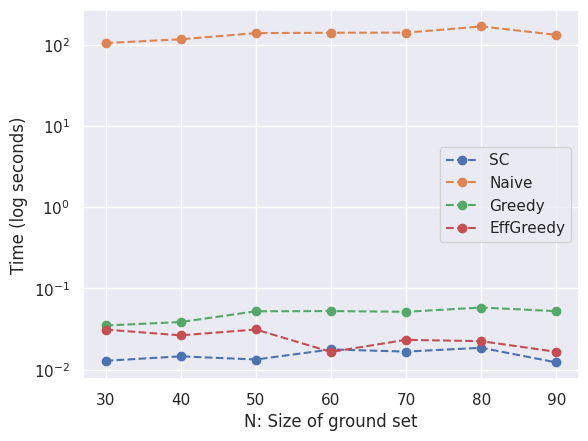

In [ ]:
ax = plt.axes()
# ax.plot(result_df_times_1.loc[(result_df_times_1["N"] >= 10) & (result_df_times_1["N"] <= 80)].groupby("N").mean()["AllPick"], marker="o", linestyle="--", label="Color Probs: (0.33, 0.33, 0.33)")
# ax.plot(result_df_times_2.loc[(result_df_times_2["N"] >= 10) & (result_df_times_2["N"] <= 80)].groupby("N").mean()["AllPick"], marker="o", linestyle="--", label="Color Probs: (0.1, 0.2, 0.7)")
# ax.plot(result_df_times_3.loc[(result_df_times_3["N"] >= 20) & (result_df_times_3["N"] <= 60)].groupby("N").mean()["EffAllPick"], marker="o", linestyle="--", label="Color Probs: (0.2, 0.8)")
ax.plot(result_df_times.groupby("N").mean(), marker="o", linestyle="--")
ax.legend(algs)
# plt.legend()
plt.yscale("log")
plt.xlabel("N: Size of ground set")
plt.ylabel("Time (log seconds)")
# plt.title("EffAllPick Algorithm Times")

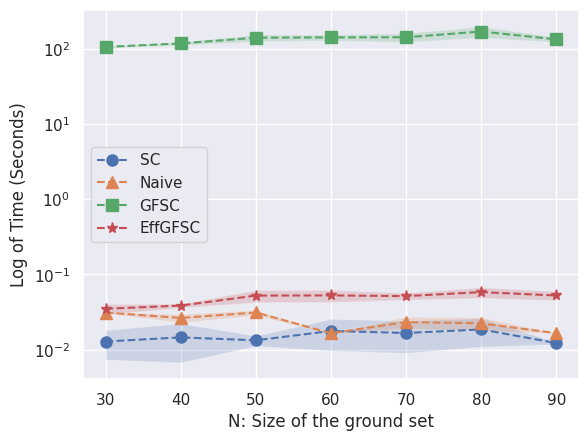

In [ ]:
sns.set()
means = result_df_times.groupby("N").mean()
x = means.index.values
stds = result_df_times.groupby("N").std()
mins = result_df_times.groupby("N").min()
maxs = result_df_times.groupby("N").max()


for alg in algs:
    if alg == "N":
        continue
    plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8)
    plt.fill_between(x, means[alg] - stds[alg] / 2, means[alg] + stds[alg] / 2, alpha=0.2)

plt.legend(loc="center left")
plt.yscale("log")
plt.xlabel("N: Size of the ground set")
plt.ylabel("Log of Time (Seconds)")
plt.show()

Text(0, 0.5, 'Size of Cover')

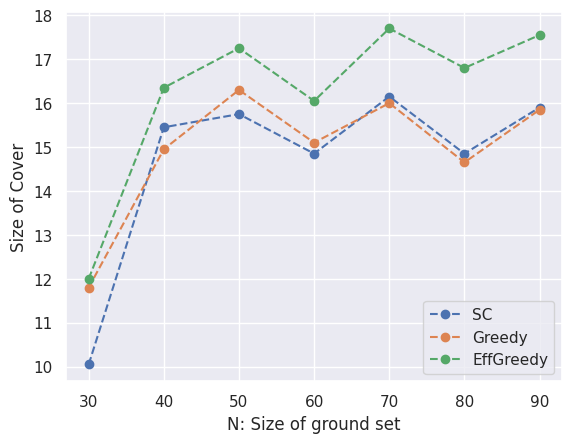

In [ ]:
ax = plt.axes()
ax.plot(result_df_counts.groupby("N").mean(), marker="o", linestyle="--")
ax.legend(["SC", "Greedy", "EffGreedy"])
# plt.legend()
plt.xlabel("N: Size of ground set")
plt.ylabel("Size of Cover")
# plt.title("Size of cover for EffAllPick algorithm")

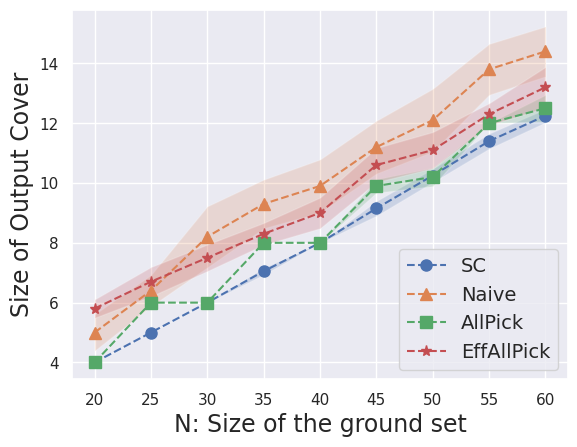

In [33]:
d = result_df_counts.loc[result_df_counts["N"] >= 20]

sns.set()
means = d.groupby("N").mean()
x = means.index.values
stds = d.groupby("N").std()
mins = d.groupby("N").min()
maxs = d.groupby("N").max()


for alg in algs:
    if alg == "N":
        continue
    plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8)
    plt.fill_between(x, means[alg] - stds[alg] / 2, means[alg] + stds[alg] / 2, alpha=0.2)

plt.legend(loc="lower right", prop={'size': 14})
plt.xlabel("N: Size of the ground set", fontsize=17)
plt.ylabel("Size of Output Cover", fontsize=17)

# plt.title("Comparing Cover Size")
plt.show()

Text(0, 0.5, 'Fairness Ratio')

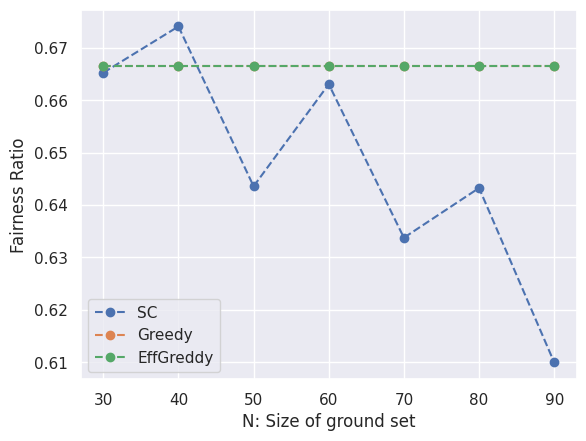

In [ ]:
ax = plt.axes()
ax.plot(result_df_fairness_red.groupby("N").mean(), marker='o', linestyle='--')
ax.legend(["SC", "Greedy", "EffGreddy"])
plt.xlabel("N: Size of ground set")
plt.ylabel("Fairness Ratio")
# plt.ylim(0, 2)
# plt.yticks(np.arange(0, 1, 0.1));

In [ ]:
result_df_fairness_blue.head()

,N,SC,Greedy,EffGreedy
0,30,0.181818,0.333333,0.333333
1,30,0.200000,0.333333,0.333333
2,30,0.300000,0.333333,0.333333
3,30,0.300000,0.333333,0.333333
4,30,0.300000,0.333333,0.333333


In [ ]:
result_df_fairness_red

,N,SC,Greedy,EffGreedy
0,30,0.818182,0.666667,0.666667
1,30,0.800000,0.666667,0.666667
2,30,0.700000,0.666667,0.666667
3,30,0.700000,0.666667,0.666667
4,30,0.700000,0.666667,0.666667
...,...,...,...,...
135,90,0.733333,0.666667,0.666667
136,90,0.750000,0.666667,0.666667
137,90,0.562500,0.666667,0.666667
138,90,0.352941,0.666667,0.666667


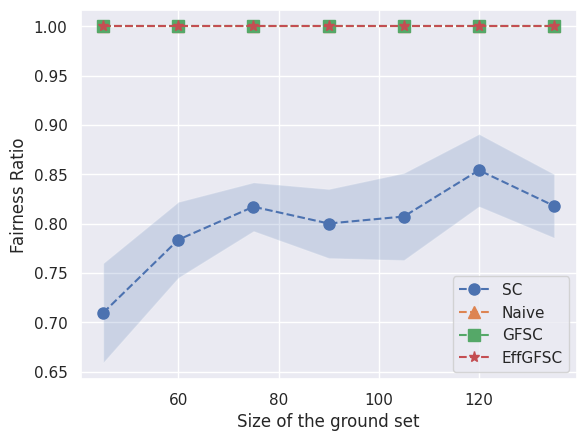

In [ ]:
# result_df_fairness_blue[result_df_fairness_blue["N"] == 30]["fairness"]
d = copy.deepcopy(result_df_fairness_red)
d2 = copy.deepcopy(result_df_fairness_blue)

for alg in d.keys():
    d[alg] = d[alg] / 0.666667
    tmp = d2[alg] / (1 - 0.666667)
    d[alg] = np.minimum(tmp, d[alg])

sns.set()
means = d.groupby("N").mean()
x = means.index.values
stds = d.groupby("N").std()
mins = d.groupby("N").min()
maxs = d.groupby("N").max()


for alg in algs:
    if alg == "N":
        continue
    plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8)
    plt.fill_between(x, means[alg] - stds[alg] / math.sqrt(20), means[alg] + stds[alg] / math.sqrt(20), alpha=0.2)

plt.legend(loc="lower right")
plt.xlabel("Size of the ground set")
plt.ylabel("Fairness Ratio")
plt.show()